In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.calibration import CalibratedClassifierCV

In [3]:
from tqdm import tqdm
from math import log10
from sklearn import preprocessing
from sklearn import metrics

In [1]:
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold

2. Active Learning Using Support Vector Machines   
   
(a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a
binary classification problem.

In [4]:
df = pd.read_csv('dba.csv')

In [5]:
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [6]:
df = shuffle(df).reset_index(drop=True)
test_data = df[:472]
train_data = df[472:]
print(train_data.shape, test_data.shape)

(900, 5) (472, 5)


In [7]:
def get_c_range(x_train, y_train):
    c_ = np.logspace(-5, 8, 10)
    scores = []
    for c in c_:
        svc = LinearSVC(penalty='l1', C=c, dual=False)
        svc.fit(x_train, y_train)
        scores.append(svc.score(x_train, y_train))
    scores = np.array(scores)
    ind = np.argwhere(scores > 0.9).flatten()
    c_1 = c_[ind[0]]
    c_2 = c_[ind[-1]]
    return c_1, c_2

(b) Repeat each of the following two procedures 50 times. You will have 50 errors for
90 SVMs per each procedure.   
   
i. Train a SVM with a pool of 10 randomly selected data points from the training
set using linear kernel and L1 penalty. Select the penalty parameter using
10-fold cross validation.2 Repeat this process by adding 10 other randomly
selected data points to the pool, until you use all the 900 points. Do NOT
replace the samples back into the training set at each step. Calculate the
test error for each SVM. You will have 90 SVMs that were trained using 10,
20, 30, ... , 900 data points and their 90 test errors. You have implemented
passive learning.   

In [8]:
results = []

for i in tqdm(range(1)):
    train_data = shuffle(train_data)
    test_data = shuffle(test_data)
    x_test = test_data.iloc[:, :-1]
    y_test = test_data.iloc[:, -1]
    
    each = []
    
    for j in range(0, 900, 10):
        x_train = train_data.iloc[:10+j, :-1]
        y_train = train_data.iloc[:10+j, -1]
        #print(x_train.shape, y_train.shape)
        
        c_l, c_h = get_c_range(x_train, y_train)
        parameters = {'C':np.logspace(log10(c_l), log10(c_h), 20)}

        svc = LinearSVC(penalty='l1', dual=False)
        kf = KFold(n_splits=10, shuffle=True)
        clf = GridSearchCV(svc, parameters, cv=kf, scoring='accuracy', return_train_score=True)
        clf.fit(x_train, y_train)

        #calculating test accuracy
        sv = clf.best_estimator_
        y_pred = sv.predict(x_test)

        each.append(1 - metrics.accuracy_score(y_test, y_pred))
        print('Test Error {}'.format(1 - round(metrics.accuracy_score(y_test, y_pred), 2)))
    results.append(np.mean(each))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(10, 4) (10,)
Test Error 0.06999999999999995
(20, 4) (20,)
Test Error 0.030000000000000027
(30, 4) (30,)
Test Error 0.010000000000000009
(40, 4) (40,)
Test Error 0.020000000000000018
(50, 4) (50,)
Test Error 0.020000000000000018
(60, 4) (60,)
Test Error 0.030000000000000027
(70, 4) (70,)
Test Error 0.030000000000000027
(80, 4) (80,)
Test Error 0.020000000000000018
(90, 4) (90,)
Test Error 0.020000000000000018
(100, 4) (100,)
Test Error 0.020000000000000018
(110, 4) (110,)
Test Error 0.020000000000000018
(120, 4) (120,)
Test Error 0.010000000000000009
(130, 4) (130,)
Test Error 0.010000000000000009
(140, 4) (140,)
Test Error 0.010000000000000009
(150, 4) (150,)
Test Error 0.010000000000000009
(160, 4) (160,)
Test Error 0.010000000000000009
(170, 4) (170,)
Test Error 0.010000000000000009
(180, 4) (180,)
Test Error 0.010000000000000009
(190, 4) (190,)
Test Error 0.010000000000000009
(200, 4) (200,)
Test Error 0.010000000000000009
(210, 4) (210,)
Test Error 0.010000000000000009
(220, 4) (2

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:57<00:00, 297.11s/it]


ii. Train a SVM with a pool of 10 randomly selected data points from the training
set3 using linear kernel and L1 penalty. Select the parameters of the SVM
with 10-fold cross validation. Choose the 10 closest data points in the training
set to the hyperplane of the SVM4 and add them to the pool. Do not replace
the samples back into the training set. Train a new SVM using the pool.
Repeat this process until all training data is used. You will have 90 SVMs
that were trained using 10, 20, 30,..., 900 data points and their 90 test errors.
You have implemented active learning.

In [16]:
results1 = []

for i in tqdm(range(1)):
    train_data = shuffle(train_data)
    test_data = shuffle(test_data)
    
    x_train_taken = train_data.iloc[:10, :-1].reset_index(drop=True)
    y_train_taken = train_data.iloc[:10, -1].reset_index(drop=True)
    train_nottak = train_data.iloc[10:, :].reset_index(drop=True)
    
    x_test = test_data.iloc[:, :-1]
    y_test = test_data.iloc[:, -1]
    
    each = []
    
    for j in range(90):
        print(x_train_taken.shape, y_train_taken.shape, train_nottak.shape)
        
        c_l, c_h = get_c_range(x_train_taken, y_train_taken)
        parameters = {'C':np.logspace(log10(c_l), log10(c_h), 20)}

        svc = LinearSVC(penalty='l1', dual=False)
        kf = KFold(n_splits=10, shuffle=True)
        clf = GridSearchCV(svc, parameters, cv=kf, scoring='accuracy', return_train_score=True)
        clf.fit(x_train_taken, y_train_taken)

        #calculating test accuracy
        sv = clf.best_estimator_
        
        if(j < 89):
            y = sv.decision_function(train_nottak.iloc[:, :-1])
            w_norm = np.linalg.norm(sv.coef_)
            dist = y / w_norm
            dist = [abs(each) for each in dist]
            train_nottak['dist'] = dist
            train_nottak = train_nottak.sort(['dist'], ascending=True)
            x_train_taken = x_train_taken.append(train_nottak.iloc[:10, :-2])
            y_train_taken = y_train_taken.append(train_nottak.iloc[:10, -2])
            train_nottak = train_nottak.iloc[10:, :-1]
        
        y_pred = sv.predict(x_test)
        each.append(round(1 - metrics.accuracy_score(y_test, y_pred), 2))
        print('Test Error {}'.format(1 - round(metrics.accuracy_score(y_test, y_pred), 2)))
    results1.append(np.mean(each))



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(10, 4) (10,) (890, 5)
Test Error 0.09999999999999998
(20, 4) (20,) (880, 5)
Test Error 0.010000000000000009
(30, 4) (30,) (870, 5)
Test Error 0.020000000000000018
(40, 4) (40,) (860, 5)
Test Error 0.030000000000000027
(50, 4) (50,) (850, 5)
Test Error 0.020000000000000018
(60, 4) (60,) (840, 5)
Test Error 0.020000000000000018
(70, 4) (70,) (830, 5)
Test Error 0.010000000000000009
(80, 4) (80,) (820, 5)
Test Error 0.010000000000000009
(90, 4) (90,) (810, 5)
Test Error 0.010000000000000009
(100, 4) (100,) (800, 5)
Test Error 0.010000000000000009
(110, 4) (110,) (790, 5)
Test Error 0.010000000000000009
(120, 4) (120,) (780, 5)
Test Error 0.010000000000000009
(130, 4) (130,) (770, 5)
Test Error 0.010000000000000009
(140, 4) (140,) (760, 5)
Test Error 0.010000000000000009
(150, 4) (150,) (750, 5)
Test Error 0.010000000000000009
(160, 4) (160,) (740, 5)
Test Error 0.010000000000000009
(170, 4) (170,) (730, 5)
Test Error 0.010000000000000009
(180, 4) (180,) (720, 5)
Test Error 0.010000000000



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:50<00:00, 290.43s/it]



(c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i
and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot
average test error versus number of training instances for both active and passive
learners on the same figure and report your conclusions. Here, you are actually
obtaining a learning curve by Monte-Carlo simulation.

In [12]:
import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension

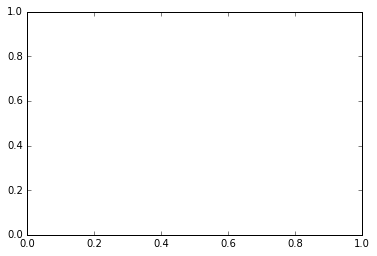

In [15]:
num_train = range(10, 901, 10)

plt.plot(num_train, results, label='passive')
plt.plot(num_train, results1, label='active')
plt.xlabel('number of training instances')
plt.ylabel('average test error')
plt.legend()

In [ ]:
diff = results.values - results1.values
plt.plot(num_train, diff)
plt.xlabel('number of training instances')
plt.ylabel('test error difference')

Conclusion:

When the number of training instances is small, active learners perform better. As the number of training instances increase, passive learners outperform active learners. When the number of training instances is sufficiently large, the performace active learners and passive learners are basicly the same.